### Importações e preparação do dataset

**Importando bibliotecas**

In [1]:
import warnings 
warnings.filterwarnings('always') 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Nadam
from keras.utils import to_categorical, np_utils
from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Lambda

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D,Conv2D,GlobalAveragePooling2D
from keras.models import Sequential, Model,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop,SGD,Adagrad,Adadelta
from keras import losses
from keras.layers import Conv2DTranspose

import random
import tensorflow as tf
import cv2
import os 
import glob

- **Preparando o dataset**

In [3]:
#Para acessar as imagens do Drive
from google.colab import drive
drive.mount('/content/drive')
root_path = "drive/My Drive/dataset/tempo/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def load_data(datadir, classes, img_size=224):
    training_data = []
    label = []
    for classe in range(len(classes)):
        path = os.path.join(datadir, classes[classe])
        shufled_list  = list(os.listdir(path))
        #shuffle(shufled_list)
        for img in shufled_list:
            img_array = cv2.imread(os.path.join(path, img))
            if img_array is None:
                continue
            #img_array = cv2.resize(img_array, (img_size, img_size))
            img_array = cv2.resize(img_array, (128,128), interpolation = cv2.INTER_AREA)
            training_data.append(img_array)
            label.append(classe)
    return training_data, label

**Definindo as labels**

In [5]:
data, label = load_data(root_path, ['cloudy','rain','shine','sunrise'])

In [6]:
label = np.array(label)
#label = keras.utils.to_categorical(label, 4)

3


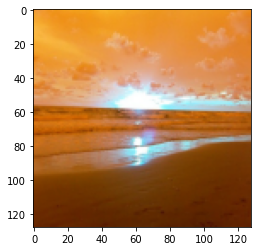

In [7]:
plt.imshow(data[800])
print(label[800])

### Pré-Processamento

In [8]:
##### Filtro de média
blur_data = []
for i in range(len(data)):
    blur_img = cv2.blur(data[i], ksize=(3,3))
    blur_data.append(blur_img)

In [9]:
##### GaussianBlur
gaussian_data = []
for i in range(len(data)):
    gaussian_img = cv2.GaussianBlur(src=data[i], ksize=(15,15),sigmaX=0)
    gaussian_data.append(gaussian_img)

In [10]:
#### Equalização do histograma - HSV
Eq_data = []
for i in range(len(data)):
    img = data[i]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    canais =  cv2.split(hsv)
    cv2.equalizeHist(canais[2],canais[2])
    cv2.merge(canais, hsv)
    Eq_data.append(cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR))

In [11]:
#### Filtro	Máscara de Desaguçamento - filtro de realce
realce_data = []
for i in range(len(data)):
    imgOriginal = data[i]
    imgSuavizada = cv2.GaussianBlur(imgOriginal, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(imgOriginal, imgSuavizada)
    imgRealcada = cv2.add(imgOriginal, imgDetalhes)
    realce_data.append(imgRealcada)

**Normalização dos dados**

In [12]:
def normaliz(data):
  data_norm = [i/255 for i in data]
  return np.array(data_norm)

data_norm = normaliz(data)
HSV_norm = normaliz(Eq_data)
realce_norm = normaliz(realce_data)

### Separando os dados em treino, teste e validação

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_norm, label, test_size=0.20, stratify = label)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify = y_train)

In [14]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

### Aumento de dados

In [15]:
# Para evitar problemas de overfitting, usei o ImageDataGenerator.
datagen = ImageDataGenerator(
        zoom_range = 0.1, # Aleatory zoom
        rotation_range= 15, 
        width_shift_range=0.1,  # horizontal shift
        height_shift_range=0.1,  # vertical shift
        horizontal_flip=True,  
        vertical_flip=True)
datagen.fit(X_train)

#### Modelos

> InceptionV3 + ResNet

In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
def Inceptionv3():
    inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))
    model = Sequential()
    model.add(inceptionV3)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2
def Resnet101V2():

    Resnet101V2 = ResNet101V2(weights='imagenet', include_top=False, input_shape=(128,128,3))

    model = Sequential()
    model.add(Resnet101V2)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model


### Treinamento 

In [17]:
model = Inceptionv3()
history = model.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_data = (X_val, y_val))

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/200
23/23 [==============================] - 23s 260ms/step - loss: 1.0380 - accuracy: 0.6003 - val_loss: 0.7912 - val_accuracy: 0.7111
Epoch 2/200
23/23 [==============================] - 2s 94ms/step - loss: 0.2410 - accuracy: 0.9192 - val_loss: 0.4354 - val_accuracy: 0.8556
Epoch 3/200
23/23 [==============================] - 2s 94ms/step - loss: 0.1261 - accuracy: 0.9596 - val_loss: 0.3010 - val_accuracy: 0.9056
Epoch 4/200
23/23 [==============================] - 2s 94ms/step - loss: 0.0643 - accuracy: 0.9819 - val_loss: 0.2537 - val_accuracy: 0.9222
Epoch 5/200
23/23 [==============================] - 2s 95ms/step - loss: 0.0538 - accuracy: 0.9847 - val_loss: 0.1754 - val_accuracy: 0.9556
Epoch 6/200
23/23 [==============================] - 2s 102ms/step - loss: 0.0401 - accuracy: 0.9916 - val_loss: 0.1308 - val_accuracy: 0.9722
Epoch 7/200
23/23 [==============================] - 2s 95ms/step - loss: 0.0526

### Classificando alguns exemplos
Vamos classificar alguns exemplos de flores para ver onde é que nosso modelo está errando mais.

In [ ]:
pred = tf_model.predict(X_val)
pred = np.argmax(pred, axis = 1)

27/27 [==============================] - 101s 4s/step


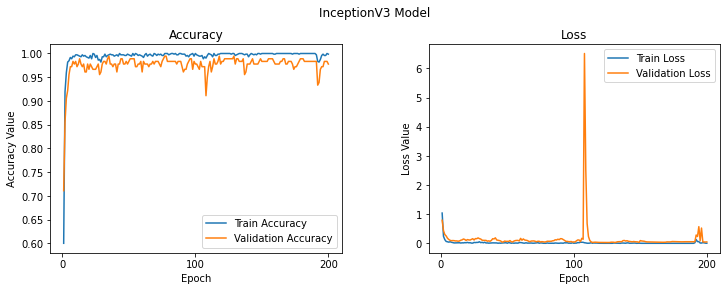

In [33]:
import matplotlib.pyplot as plt

epochs = np.shape(history.history['accuracy'])[0]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('InceptionV3 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 100))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 100))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [25]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predict = model.predict(X_test)
y_pred = np.argmax(predict, axis = 1)
y_true = np.argmax(y_test, axis = 1)

print("Acurácia:", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred, average=None))
print("Recall: ", recall_score(y_true, y_pred, average=None))
print("F1 Score: ", f1_score(y_true, y_pred, average=None))

print(classification_report(y_true, y_pred))

8/8 [==============================] - 0s 40ms/step
Acurácia: 0.96
Precision:  [0.93333333 1.         0.90196078 1.        ]
Recall:  [0.93333333 1.         0.92       0.98611111]
F1 Score:  [0.93333333 1.         0.91089109 0.99300699]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        60
           1       1.00      1.00      1.00        43
           2       0.90      0.92      0.91        50
           3       1.00      0.99      0.99        72

    accuracy                           0.96       225
   macro avg       0.96      0.96      0.96       225
weighted avg       0.96      0.96      0.96       225



**Matriz de Confusão**

In [28]:
def get_confusion_matrix1(y_true, y_pred, modelo):
  cm = confusion_matrix(y_true, y_pred)
  targetNames = ['cloudy','rain','shine','sunrise']
  tick_marks = [0, 1, 2, 3]

  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues').set(title=modelo, ylabel='True Label', xlabel='Predicted Label')

  plt.xticks(tick_marks, np.array(targetNames))
  plt.yticks(tick_marks, np.array(targetNames))
  plt.tight_layout()

In [29]:
def get_confusion_matrix(y_true, y_pred, modelo):
    labels = ['cloudy','rain','shine','sunrise']
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues').set(title=modelo, ylabel='True Label', xlabel='Predicted Label')

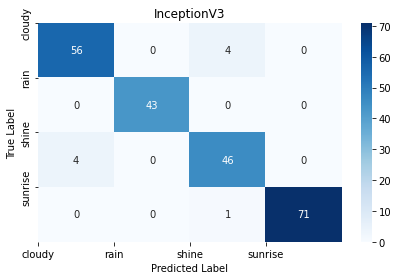

In [31]:
get_confusion_matrix1(y_true, y_pred, "InceptionV3")

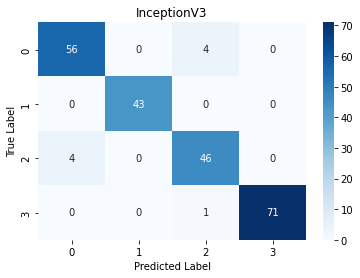

In [32]:
get_confusion_matrix(y_true, y_pred, "InceptionV3")